In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import ariel_load
import tqdm

local


In [2]:
%%time
train_data = kgs.load_all_train_data()
test_data = kgs.load_all_test_data()
len(train_data), len(test_data)

CPU times: user 496 ms, sys: 93.9 ms, total: 590 ms
Wall time: 1.73 s


(1100, 1)

In [3]:
def robust_linear_fit_rms(X, Y, drop_frac=0.05):
    X = np.asarray(X)
    Y = np.asarray(Y)

    # Fit Y = aX + b using least squares
    A = np.vstack([X, np.ones_like(X)]).T
    a, b = np.linalg.lstsq(A, Y, rcond=None)[0]

    # Predicted Y and residuals
    Y_pred = a * X + b
    residuals = Y - Y_pred
    abs_resid = np.abs(residuals)

    # Remove worst 5% (highest absolute residuals)
    if drop_frac>0:
        n = len(residuals)
        keep = int(n * (1 - drop_frac))
        indices = np.argpartition(abs_resid, keep)[:keep]
    #print(keep, len(residuals))
    else:
        indices = np.arange(len(residuals))

    # Compute RMS of the remaining residuals
    rms = np.sqrt(np.mean(residuals[indices] ** 2))
    print(a,b)
    return rms

Inferring:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

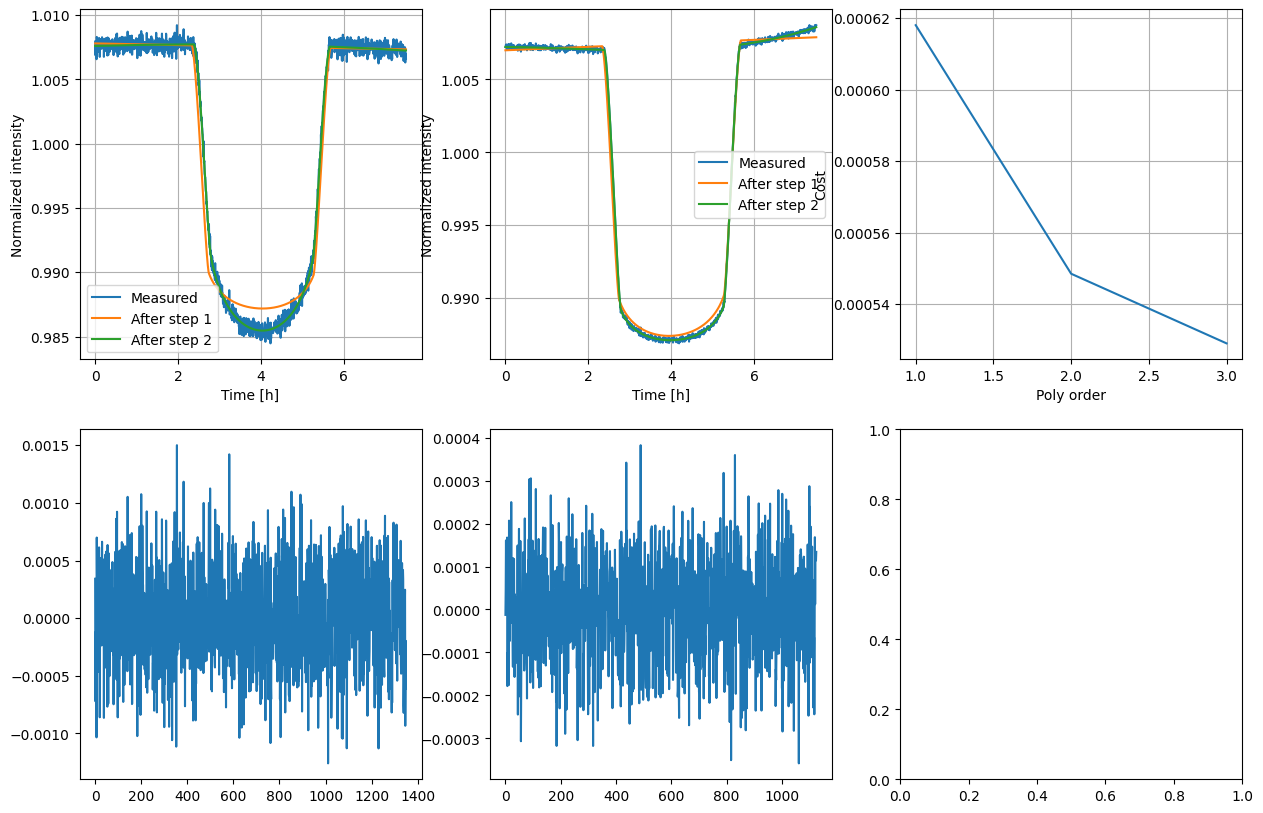

Inferring:  10%|███████▎                                                                 | 1/10 [00:01<00:15,  1.76s/it]

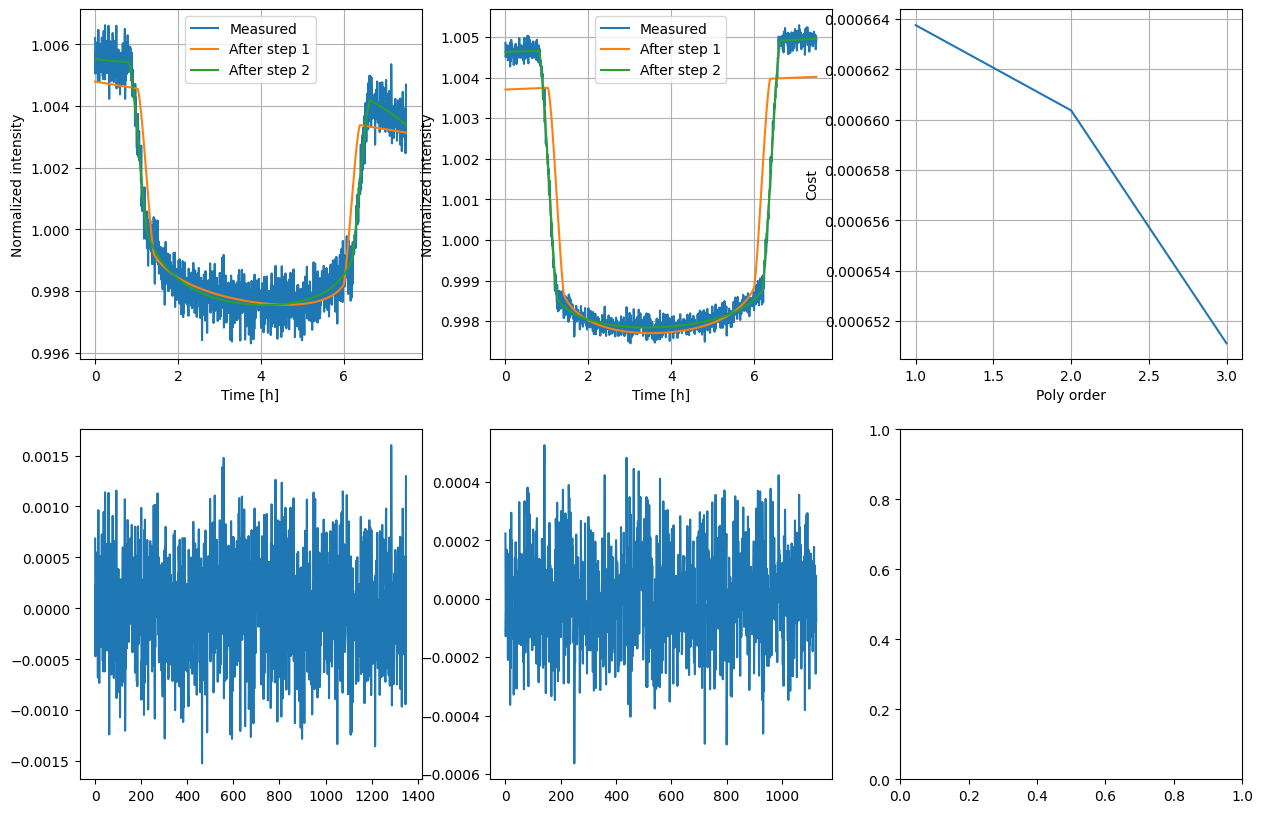

Inferring:  20%|██████████████▌                                                          | 2/10 [00:03<00:13,  1.74s/it]

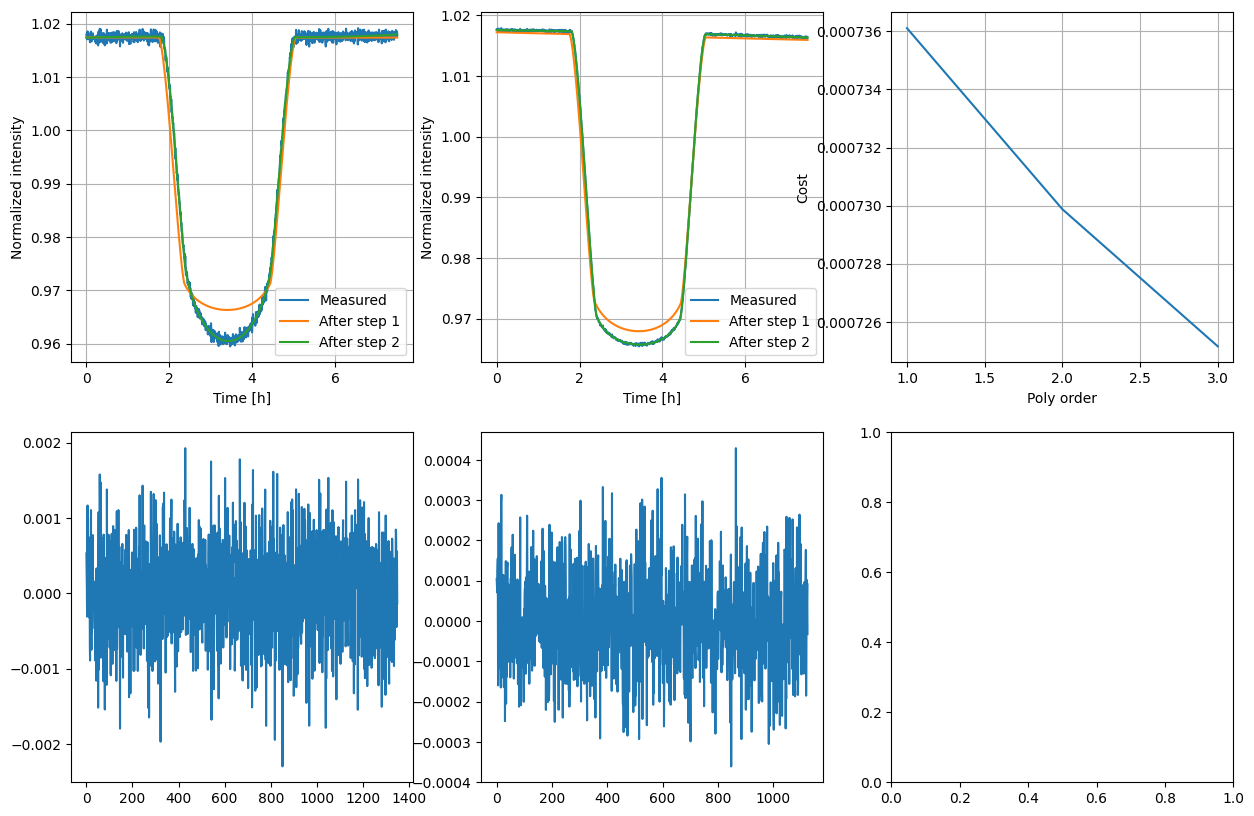

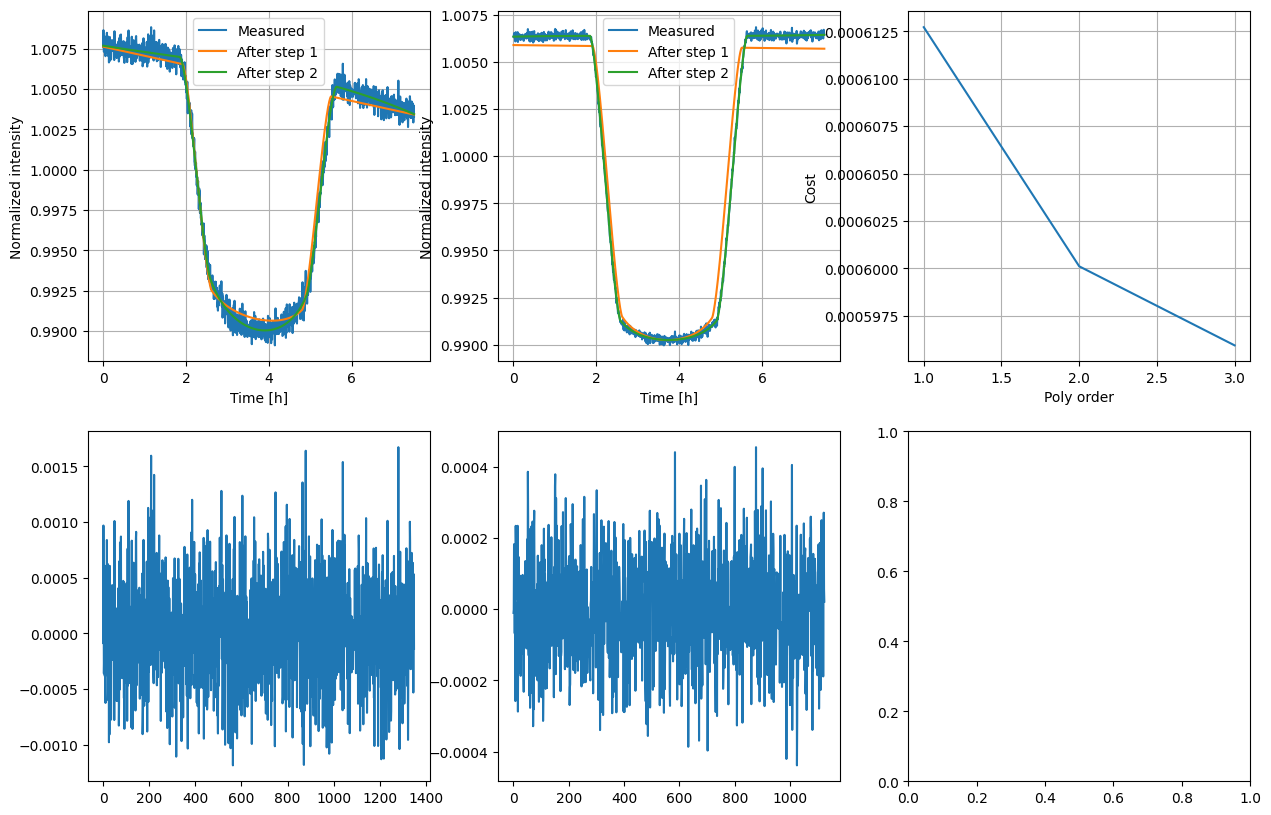

Inferring:  40%|█████████████████████████████▏                                           | 4/10 [00:04<00:06,  1.13s/it]

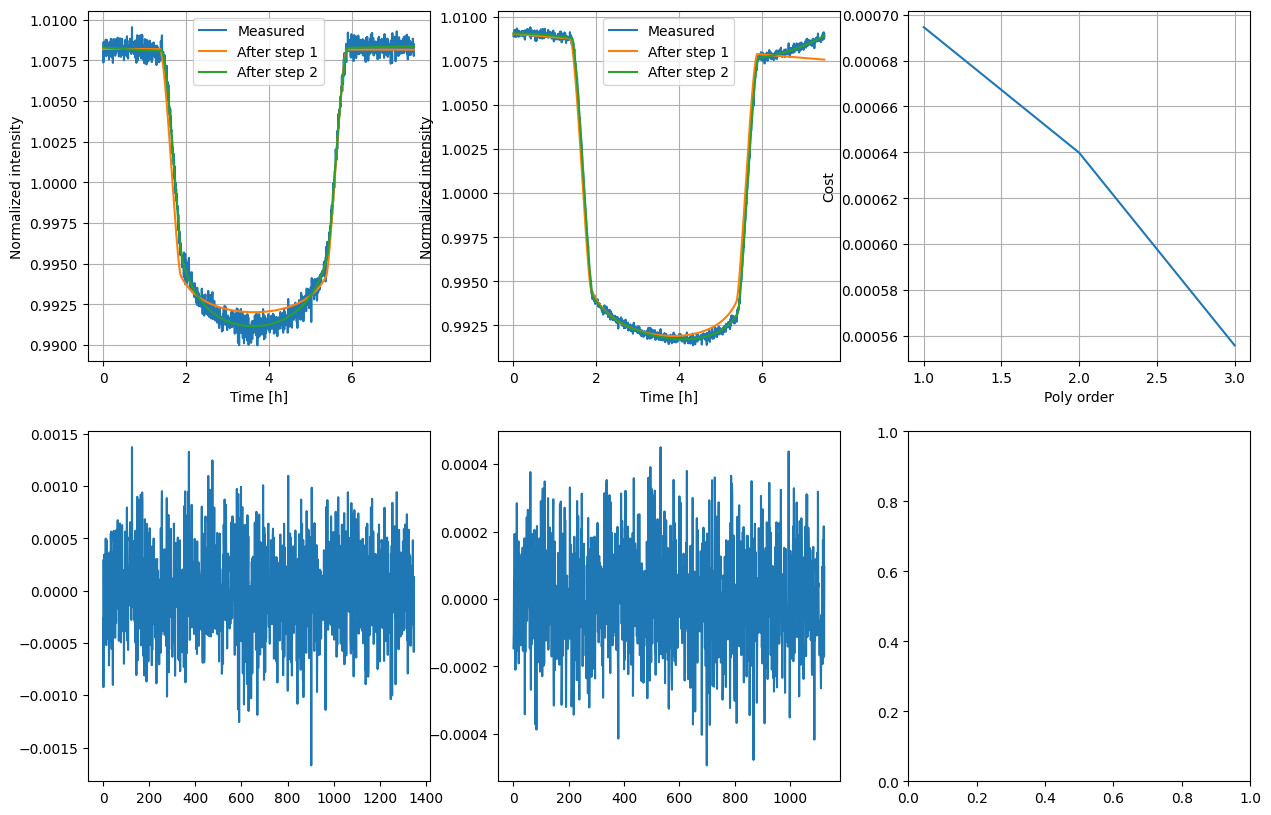

Inferring:  50%|████████████████████████████████████▌                                    | 5/10 [00:06<00:06,  1.21s/it]

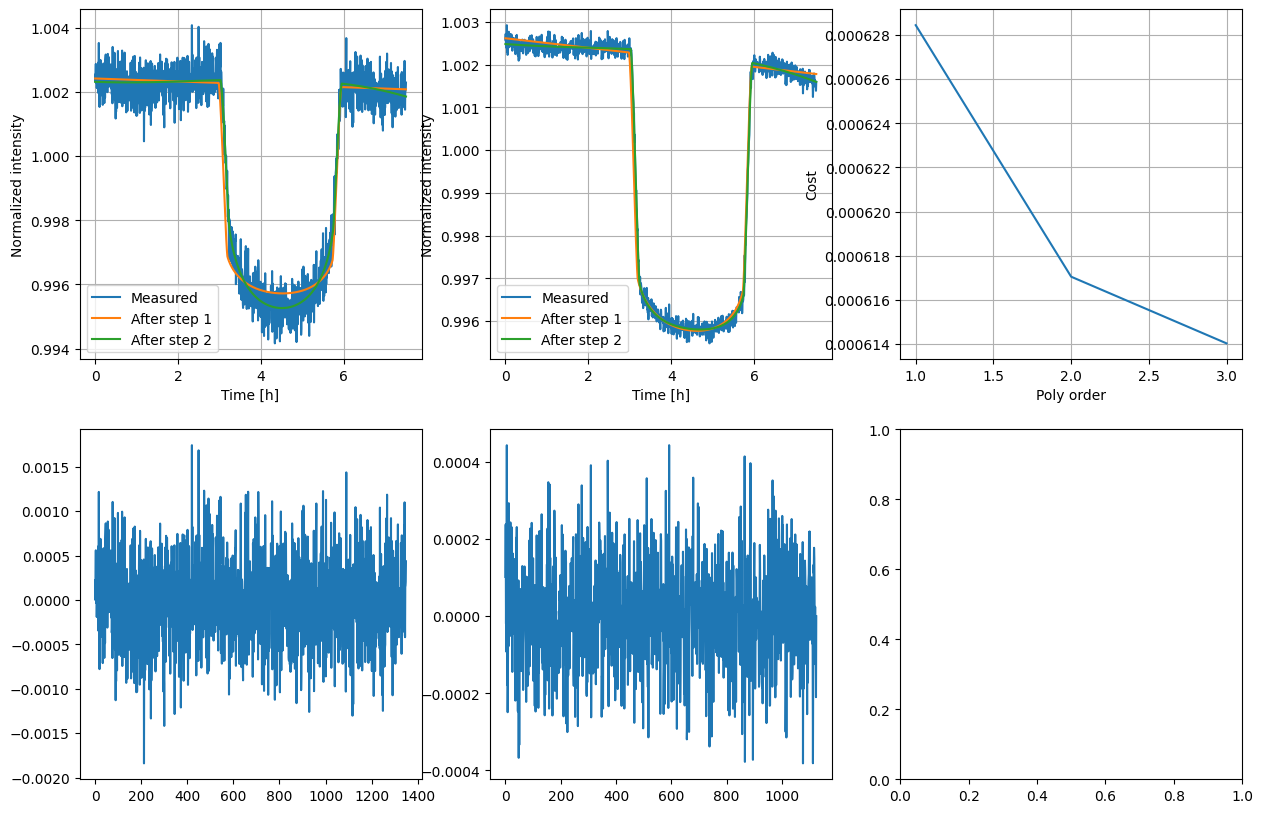

Inferring:  60%|███████████████████████████████████████████▊                             | 6/10 [00:07<00:04,  1.21s/it]

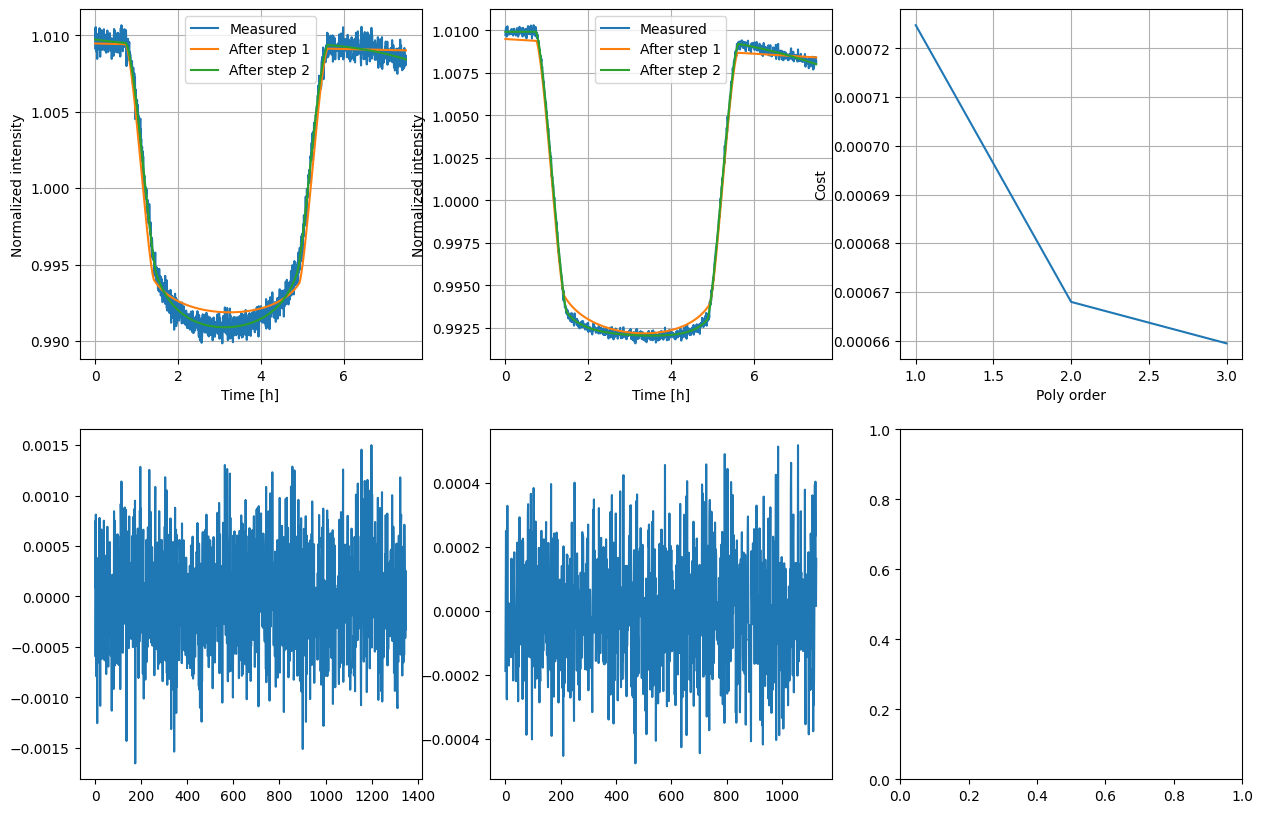

Inferring:  70%|███████████████████████████████████████████████████                      | 7/10 [00:08<00:03,  1.26s/it]

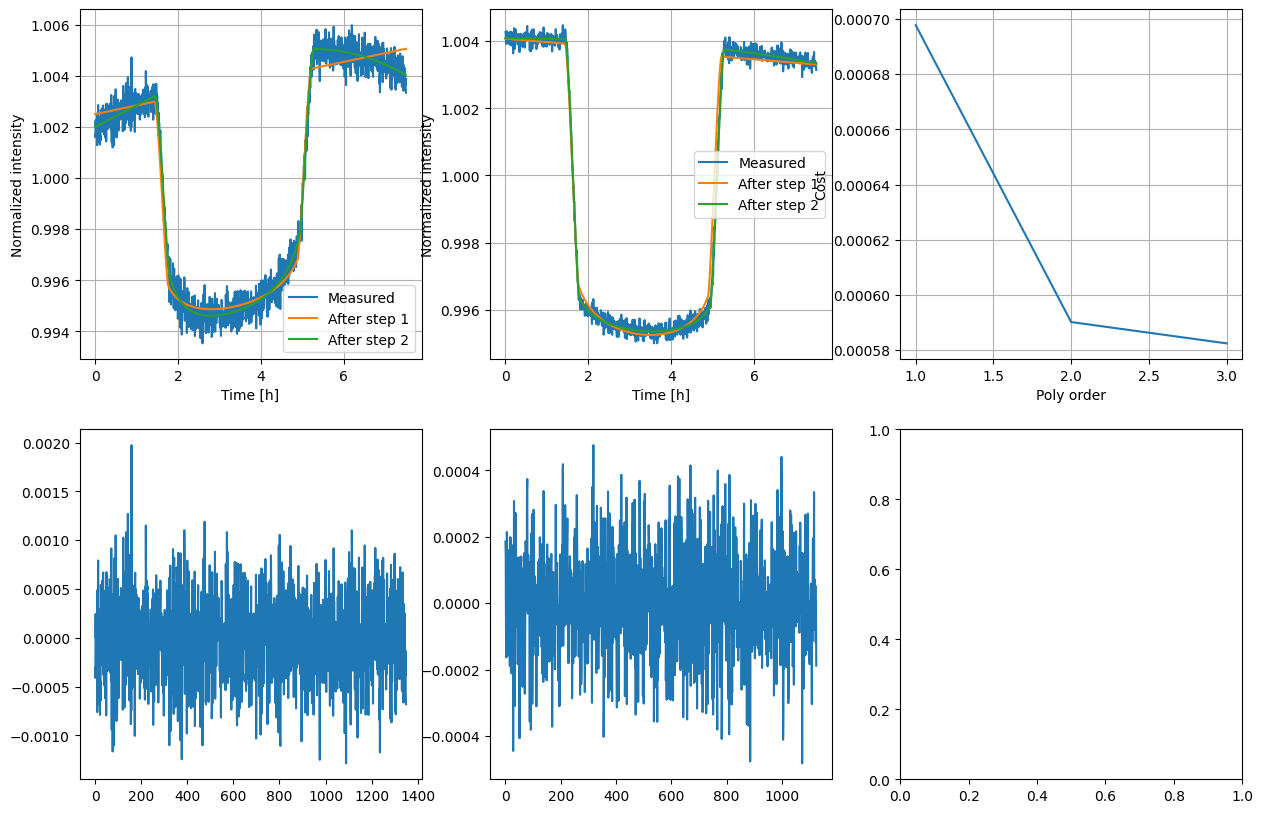

Inferring:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [00:10<00:02,  1.31s/it]

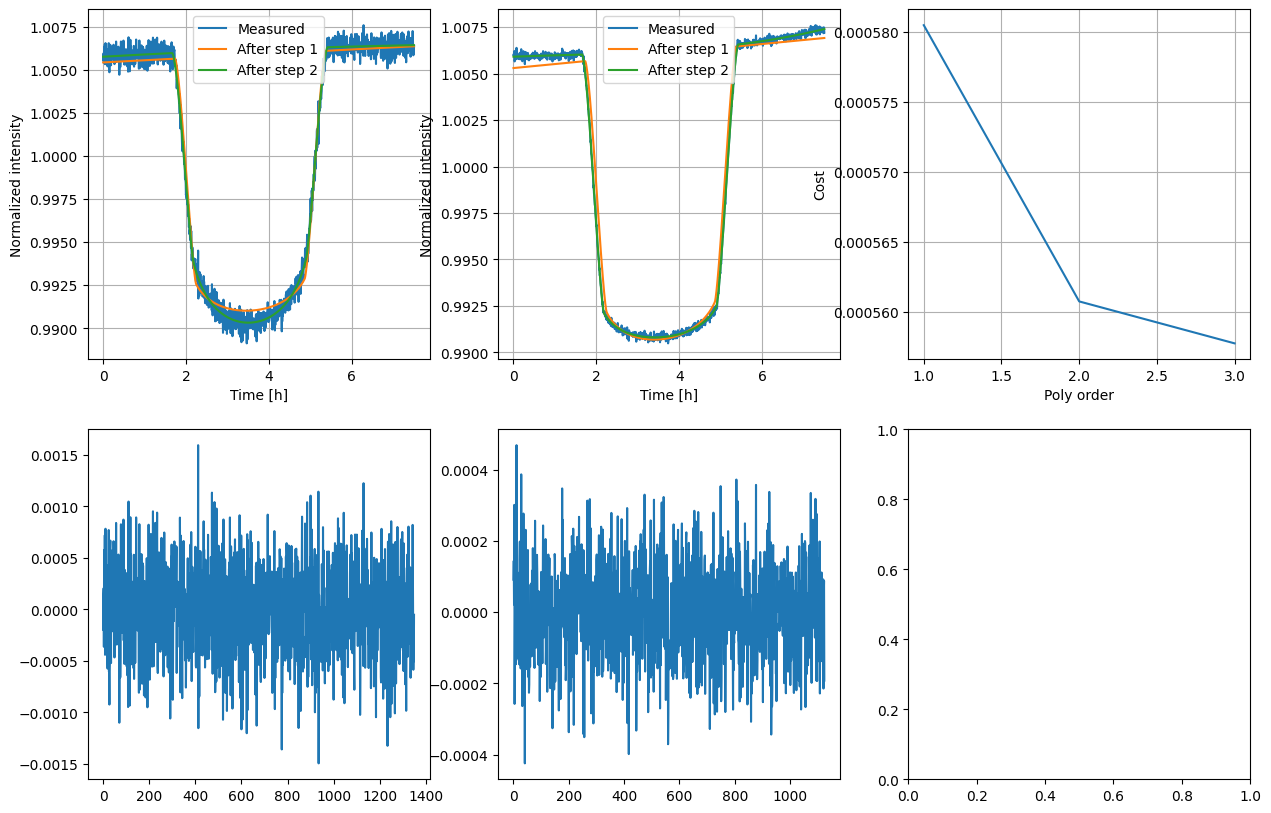

Inferring:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [00:11<00:01,  1.32s/it]

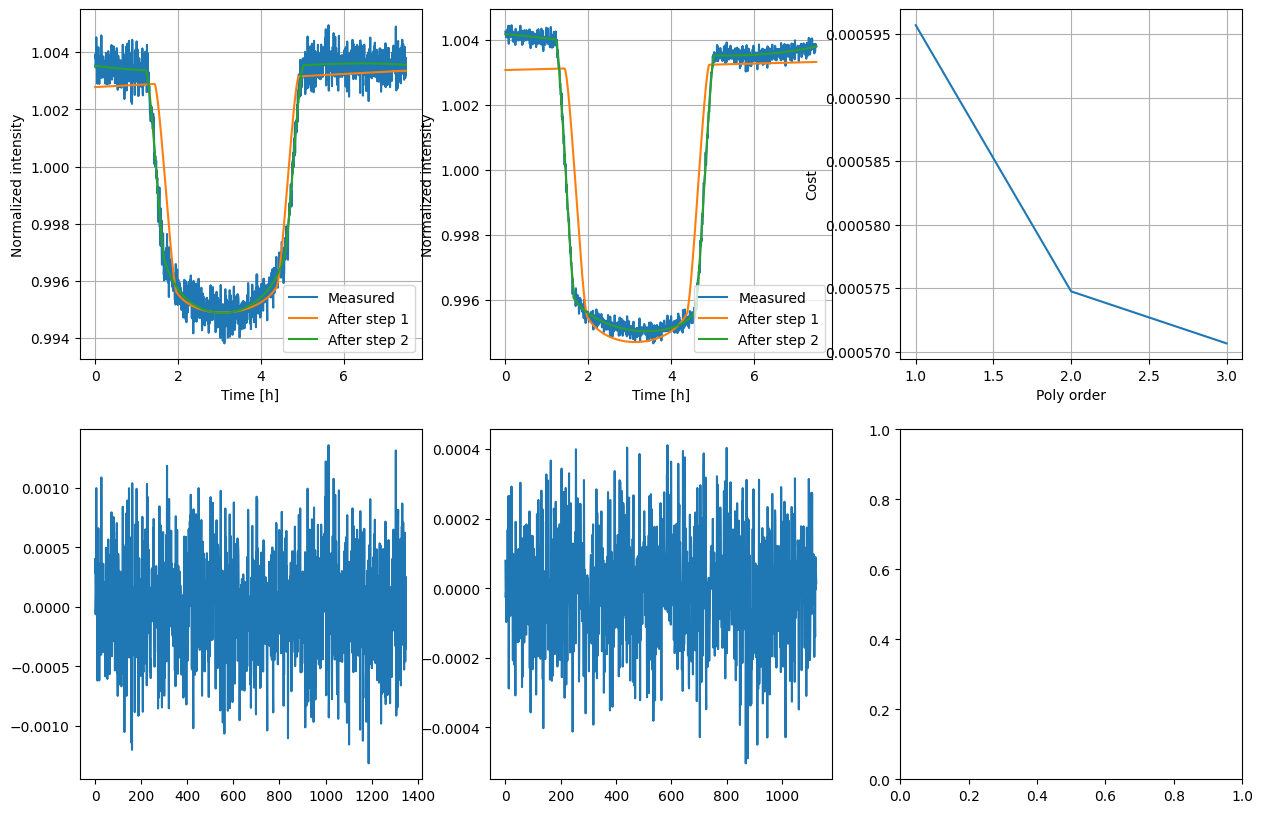

Inferring: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]


In [11]:
import ariel_simple
importlib.reload(ariel_simple)
model = ariel_simple.SimpleModel()
model.do_plots=True
model.run_in_parallel = False    
model.train(train_data)
#model.bias_a = [0.,0.]
#model.bias_b = [0.,0.]
data = train_data[:10]
inferred_data = model.infer(data)

In [6]:
%debug

> /mnt/d/ariel2/code/core/ariel_simple.py(68)_from_x()
     66         for ii in range(2):
     67             for jj in range(len(self.poly_vals[ii])):
---> 68                 self.poly_vals[ii][jj] = x[cur_ind]
     69                 cur_ind+=1
     70         if kgs.debugging_mode>=2:



ipdb>  len(x)


12


ipdb>  cur_ind


12


ipdb>  ii


1


ipdb>  jj


0


ipdb>  q


In [ ]:
for ii in range(2):
    print(inferred_data[ii].diagnostics['t_ingress'],inferred_data[ii].diagnostics['t_egress'])
    plt.figure()
    plt.plot(model._times[0], model.pred[0])

In [ ]:
%debug

In [ ]:
import ariel_simple
importlib.reload(ariel_simple)
df = 0.05
for jj in [0]:
    model = ariel_simple.SimpleModel()
    model.run_in_parallel = True
    match jj:
        case 0:
            name = 'Default'
        case 1:
            name = 'Use correction factor'
            model.use_correction_factor = True        
    model.do_plots = False
    model.train(train_data)
    #model.bias_a = [0.,0.]
    #model.bias_b = [0.,0.]
    data = train_data
    inferred_data = model.infer(data)
    print(name)
    solution = kgs.make_submission_dataframe(data, include_sigma=False)
    submission = kgs.make_submission_dataframe(inferred_data, False)
    print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
    print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
         1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))
    kgs.sanity_checks['simple_residual_diff_FGS'] = kgs.SanityCheckValue('simple_residual_diff_FGS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_FGS'].seen_all = [d.diagnostics['simple_residual_diff_FGS'] for d in inferred_data]
    kgs.sanity_checks['simple_residual_diff_AIRS'] = kgs.SanityCheckValue('simple_residual_diff_AIRS', 12, [-1,1])
    kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all = [d.diagnostics['simple_residual_diff_AIRS'] for d in inferred_data]
    kgs.dill_save(kgs.temp_dir + '/test_simple.pickle', (data,inferred_data,kgs.sanity_checks))

In [ ]:
print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
    1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))

In [ ]:
score, rms_err = kgs.score_metric(inferred_data, data)
#np.sqrt(np.diag(inferred_data[0].spectrum_cov))

In [ ]:
import copy
data_sim = copy.deepcopy(data)
sig = rms_err
for ii,d in enumerate(data_sim):
    d.spectrum += np.random.default_rng(seed=ii).normal(0,sig,size=d.spectrum.shape)
    d.spectrum_cov = np.diag(0*d.spectrum+sig**2)
    d.check_constraints()
print('Theoretical')
kgs.score_metric(data_sim, data);

In [ ]:
kgs.print_sanity_checks()

In [ ]:
plt.figure();
plt.scatter(kgs.sanity_checks['simple_residual_diff_FGS'].seen_all, solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy())
plt.figure();
plt.scatter(kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all, np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))

In [ ]:
plt.figure()
plt.plot(kgs.sanity_checks['simple_residual_diff_FGS'].seen_all)
plt.plot(kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all)
plt.legend(('FGS', 'AIRS'))
plt.grid(True)

In [ ]:
solution = kgs.make_submission_dataframe(data, include_sigma=False)
submission = kgs.make_submission_dataframe(inferred_data, False)


In [ ]:
kgs.rms(solution.iloc[:,1:2].to_numpy()-submission.iloc[:,1:2].to_numpy()),kgs.rms(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy())

In [ ]:
_,ax=plt.subplots(1,2,figsize=(10,5))
plt.sca(ax[0])
plt.box(True);plt.grid(True);
plt.scatter(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy())
plt.title(1e6*kgs.rms(solution.iloc[:,1:2].to_numpy()-submission.iloc[:,1:2].to_numpy()))
plt.sca(ax[1])
plt.box(True);plt.grid(True);
plt.scatter(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))
plt.title(1e6*kgs.rms(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy()))

In [ ]:
ind = np.argmax(np.abs(np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1)))
ind

In [ ]:
plt.scatter([len(d.transits) for d in train_data],np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1))

In [ ]:
plt.scatter([d.i for d in train_data],kgs.sanity_checks['simple_residual_diff_AIRS'].seen_all)

In [ ]:
import ariel_simple
importlib.reload(ariel_simple)
df = 0.05
model = ariel_simple.SimpleModel()
model.run_in_parallel = True  
model.do_plots = False
#model.bias_a = [0.,0.]
#model.bias_b = [0.,0.]
data = train_data[:50]
model.train(data)
inferred_data = model.infer(data)
solution = kgs.make_submission_dataframe(data, include_sigma=False)
submission = kgs.make_submission_dataframe(inferred_data, False)
print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
     1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))
kgs.score_metric(inferred_data,data)

In [ ]:
import ariel_model
importlib.reload(ariel_model)
df = 0.05
model = ariel_simple.SimpleModel()
model.run_in_parallel = True  
model.do_plots = False
model.bias_a = [0.,0.]
model.bias_b = [0.,0.]
model = ariel_model.Fudger(model=model)
data = train_data[:5]
print('5')
model.train(data)
inferred_data = model.infer(data)
solution = kgs.make_submission_dataframe(data, include_sigma=False)
submission = kgs.make_submission_dataframe(inferred_data, False)
print(1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=df), 1e6*robust_linear_fit_rms(solution.iloc[:,1].to_numpy(), solution.iloc[:,1].to_numpy()-submission.iloc[:,1].to_numpy(), drop_frac=0))
print(1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=df),
     1e6*robust_linear_fit_rms(np.mean(solution.iloc[:,2:284].to_numpy(),1), np.mean(solution.iloc[:,2:284].to_numpy()-submission.iloc[:,2:284].to_numpy(),1),drop_frac=0))
kgs.score_metric(inferred_data,data)

In [ ]:
model.sigma_fudge

In [ ]:
%debug